In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
from random import randint, random

In [3]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

path = '/content/drive/MyDrive/Colab Notebooks/four-corners/'

In [4]:
def mask(image: np.ndarray, points1: np.ndarray, cover: np.ndarray) -> np.ndarray:
    I1 = image.copy()
    I2 = cover.copy()
    points2 = np.array([(0,0),(I2.shape[1],0),(I2.shape[1],I2.shape[0]),(0,I2.shape[0])]).astype(np.float32)
    H = cv2.getPerspectiveTransform(points2, points1)
    output_size = (I1.shape[1], I1.shape[0])
    J = cv2.warpPerspective(I2, H, output_size)
    # cv2_imshow(I1)
    # cv2_imshow(I2)
    # cv2_imshow(J)
    counter=0
    for i in range(len(I1)):
        for j in range(len(I1[0])):
            black = [0,0,0]
            if not(J[i,j] == black).all():
                I1[i,j]=J[i,j]
    # cv2_imshow(I1)
    return I1

In [5]:
def blur(image: np.ndarray, points: np.ndarray) -> np.ndarray:
    plate = extract(image, points)
    # plate = cv2.boxFilter(plate, -1, (17, 17))
    plate = cv2.GaussianBlur(plate, (17, 17), 0)
    output = mask(image, points, plate)
    return output

In [6]:

def extract(image: np.ndarray, points: np.ndarray) -> np.ndarray:
    m = 450
    n = 100
    output_size = (m,n)
    points2 = np.array([(0, 0), (m, 0), (m, n), (0, n)]).astype(np.float32)
    H = cv2.getPerspectiveTransform(points, points2)
    J = cv2.warpPerspective(image, H, output_size)
    # for i in range(4):
    #     cv2.circle(image, (int(points[i, 0]), int(points[i, 1])), 3, [0, 0, 255], 2)
    #     cv2.circle(image, (int(points2[i, 0]), int(points2[i, 1])), 7, [0, 0, 255], 2)
    # cv2_imshow(image)
    # cv2.waitKey(0)
    # cv2_imshow(J)
    # cv2.waitKey(0)
    return J

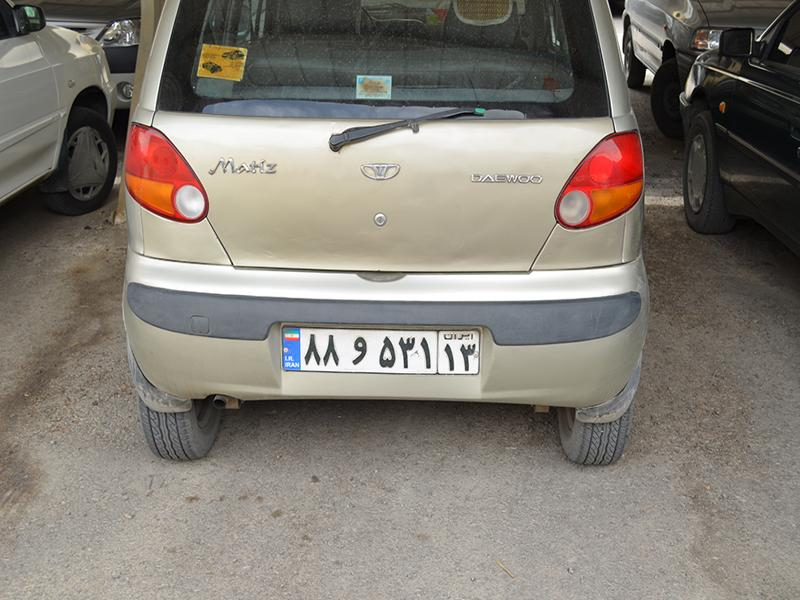

In [7]:
im = cv2.imread(path+'images/128.jpg')
with open(path+'labels/128.txt', "r") as f:
  ln = f.readline()
ln = ln.replace('\n','')
ln = ln.split(' ')
ln = ln[1:]
ln = [float(i) for i in ln]
pts = np.array([(ln[0], ln[1]), (ln[2], ln[3]), (ln[4], ln[5]), (ln[6], ln[7])]).astype(np.float32)
cv2_imshow(blur(np.array(im),pts))

In [8]:
import pandas as pd
import os
from random import shuffle

def data_to_df(data_dir):
    image_list = os.listdir(data_dir+"images")
    # print(image_list)
    return image_list

train_dir = '/content/drive/MyDrive/Colab Notebooks/four-corners/'
image_list = data_to_df(train_dir)

In [9]:
val_size = 0.2
shuffle(image_list)
train_size = int(len(image_list) * (1-val_size))
train_list = image_list[:train_size]
val_list = image_list[train_size:]

In [10]:
import cv2
import numpy as np
import os
from random import shuffle, random, randint
import pandas as pd
import math
import tensorflow as tf


### loader
def augment(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    n = randint(0,100)
    # if random() < 0.1:
    if (n % 2) == 0:
        image, points = blurring(image, points)
    if (n % 3) == 0:
        image, points = contrast(image, points)
    if (n % 5) == 0:
        image, points = random_resize(image, points)
    if (n % 7) == 0:
        image,points = shift(image, (random(),random()), points)
    if (n % 11) == 0:
        image, points = rotation(image,points)
    if (n % 13) == 0:
        image, points = crop(image,points)
    points = np.array(points)
    image = np.resize(image, (544, 544, 3))
    return image, points

def blurring(image: np.ndarray, points: np.ndarray):
    return cv2.blur(image, (10, 10)), points

def contrast(image: np.ndarray, points: np.ndarray):
    return cv2.convertScaleAbs(image, alpha=1.25, beta=8), points

def shift(img, shift, points):
    h, w = img.shape[:2]

    x = np.array(points)[[0,2,4,6]]
    y = np.array(points)[[1,3,5,7]]
    pts = np.vstack((x,y)).T
    # print("pts    ", pts)

    dy = int(shift[0] * img.shape[0])
    dx = int(shift[1] * img.shape[1])
    X = img
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0

    valid = True
    for i in range(len(pts)):
      pts[i,0] = pts[i,0]+shift[1]
      if 1 == min(pts[i,0],1):
        valid = False
      elif 0 == max(pts[i,0],0):
        valid = False
      elif 1 == min(pts[i,1],1):
        valid = False
      elif 0 == max(pts[i,1],0):
        valid = False

      # pts[i,0] = min(pts[i,0],1)
      # pts[i,0] = max(pts[i,0],0)

      # pts[i,1] = pts[i,1]+shift[0]
      # pts[i,1] = min(pts[i,1],1)
      # pts[i,1] = max(pts[i,1],0)
    if valid:
      return X, np.array(pts).flatten()
    return img, points


def rotation(image, points):
  # angle = np.random.randint(30) - 15
  angle = randint(0,30) - 15
  height, width = image.shape[:2]

  M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1.0)
  output = cv2.warpAffine(image, M, (width, height))

  x = np.array(points)[[0,2,4,6]]
  y = np.array(points)[[1,3,5,7]]
  points = np.vstack((x,y)).T
  for i in range(len(points)):
    points[i,0] *= width
    points[i,1] *= height

  # print("points    ", points)
  new_points = np.hstack([points, np.ones((len(points), 1))])
  rotated_points = M.dot(new_points.T).T
  # print("rot    ", rotated_points.shape)
  for i in range(len(rotated_points)):
    rotated_points[i,0] /= width
    rotated_points[i,1] /= height
  return np.array(output), np.array(rotated_points).flatten()


def random_resize(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # n1 = random.randint(0, 800)
    # n2 = random.randint(0, 800)
    n1 = randint(0, 800)
    n2 = randint(0, 800)
    img_shape = (n1, n2, 3)
    img = np.resize(image, img_shape)
    return img, points

def crop(img, points):

    h, w = img.shape[:2]


    x = np.array(points)[[0,2,4,6]]
    y = np.array(points)[[1,3,5,7]]
    pts = np.vstack((x,y)).T
    # print("pts    ", pts)

    min_y = np.min(pts[:,1])
    max_y = np.max(pts[:,1])
    min_x = np.min(pts[:,0])
    max_x = np.max(pts[:,0])

    # print("s     ", min_x, max_x, min_y, max_y)

    # top_y = min_y - np.random.rand() * min_y
    # bottom_y = max_y + np.random.rand() * (1-max_y)
    # left_x = min_x - np.random.rand() * min_x
    # right_x = max_x + np.random.rand() * (1-max_x)
    top_y = min_y - np.random.rand() * min_y
    bottom_y = max_y + np.random.rand() * (1-max_y)
    left_x = min_x - np.random.rand() * min_x
    right_x = max_x + np.random.rand() * (1-max_x)


    # left_x,right_x, top_y,bottom_y = 0.5074291552576565, 0.8422216223481215, 0.07256957480085441, 0.8623426533102949

    # print("g    ", left_x,right_x, top_y,bottom_y)

    left_x_px = int(left_x * w)
    right_x_px = int(right_x * w)
    top_y_px = int(top_y * h)
    bottom_y_px = int(bottom_y * h)

    # print("g    ", left_x_px,right_x_px, top_y_px,bottom_y_px)


    X = img[top_y_px:bottom_y_px, left_x_px:right_x_px,:]
    # print("x   ", X)
    # print("x shape    ", X.shape)
    # print("im sh    ", img.shape)
    # X = np.resize(X, dsize=(600, 800, 3), interpolation=cv2.INTER_CUBIC)
    X = cv2.resize(X, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    # print("x shape 2   ", X.shape)
    # X = np.asarray(X)/255
    # print("X    ", X)
    # X = img[left_x:right_x, top_y:bottom_y]

    ####
    for i in range(len(pts)):
      pts[i,0] = (pts[i,0] - left_x) / (right_x - left_x)
      # pts[i,0] = min(pts[i,0],1)
      # pts[i,0] = max(pts[i,0],0)
      ##
      pts[i,1] = (pts[i,1] - top_y) / (bottom_y - top_y)
      # # pts[i,1] = min(pts[i,1],1)
      # # pts[i,1] = max(pts[i,1],0)

    return X, np.array(pts).flatten()

# def resize(image: np.ndarray, points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
#     img_shape = (544,544,3)
#     img = np.resize(image, img_shape)
#     points = points
#     return img, points

def load(dir_name: str) -> tuple[np.ndarray, np.ndarray]:
    # returns X, y
    path = '/content/drive/MyDrive/Colab Notebooks/four-corners/'
    image_list = os.listdir(path+"images")

    X = []
    y = []

    for i in range(len(image_list)):
      file_id = image_list[i]
      img = cv2_imread(path+"images/"+file_id)
      img = np.asarray(img)/255

      label_id = file_id.replace('jpg','txt')
      label_name = path+"labels/"+label_id
      with open(label_name, "r") as f:
        ln = f.readline()
      ln = ln.replace('\n','')
      ln = ln.split(' ')
      ln = ln[1:]
      ln = [float(i) for i in ln]
      ln = np.array(ln)

      img, lbl = resize(img, ln)
      X.append(img)
      y.append(lbl)

    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.float32)
    return X, y




# Optional
class PlateDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_frame, batch_size=32, img_shape=None):
        self.data_frame = data_frame
        self.train_len = len(data_frame)
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.path = train_dir
        # self.path = '/content/drive/MyDrive/Colab Notebooks/four-corners/'

    def __len__(self):
        shuffle(self.data_frame)
        return math.ceil(self.train_len/self.batch_size)

    def on_epoch_end(self):
        shuffle(self.data_frame)

    def __data_augmentation(self, img):
        # img = tf.keras.preprocessing.image.random_shift(img, 0.2, 0.3)
        # img = tf.keras.preprocessing.image.random_rotation(img, 0.2)
        # tf.keras.preprocessing.image.random_zoom(img,
        # img = tf.image.random_flip_left_right(img)
        # img = tf.image.random_flip_up_down(img)
        return img

    def __get_image(self, file_id):
        img = cv2.imread(self.path+"images/"+file_id)
        img = cv2.resize(img, self.img_shape)
        img = np.asarray(img)/255
        return img

    def __get_label(self, label_id):
        label_id = label_id.replace('jpg','txt')
        label_name = self.path+"labels/"+label_id
        with open(label_name, "r") as f:
          ln = f.readline()
        ln = ln.replace('\n','')
        ln = ln.split(' ')
        ln = ln[1:]
        ln = [float(i) for i in ln]
        return ln

    def __getitem__(self, idx):
        batch_x = self.data_frame[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.data_frame[idx * self.batch_size:(idx + 1) * self.batch_size]
        x = [self.__get_image(file_id) for file_id in batch_x]
        y = [self.__get_label(label_id) for label_id in batch_y]
        for i in range(len(x)):
          new_x, new_y = augment(x[i], y[i])
          x.append(new_x)
          y.append(new_y)
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        return tf.convert_to_tensor(x), tf.convert_to_tensor(y)

In [53]:
train_loader = PlateDataGenerator(train_list, img_shape=(544,544))
val_loader = PlateDataGenerator(val_list, img_shape=(544,544))

In [ ]:
print(len(train_loader))
for x,y in train_loader:
  print("x    ", x.shape)
  print("y    ", y.shape)
  break

48
x     (64, 544, 544, 3)
y     (64, 8)


image    (544, 544, 3)


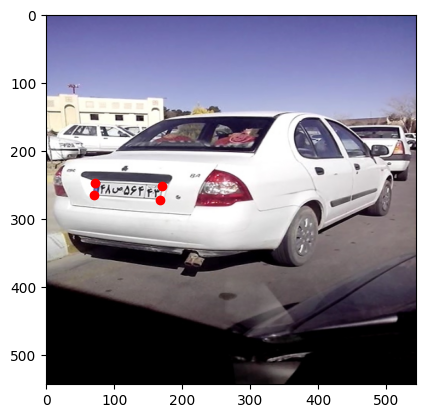

image    (544, 544, 3)


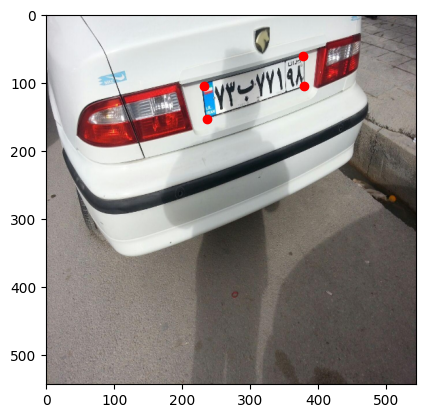

image    (544, 544, 3)


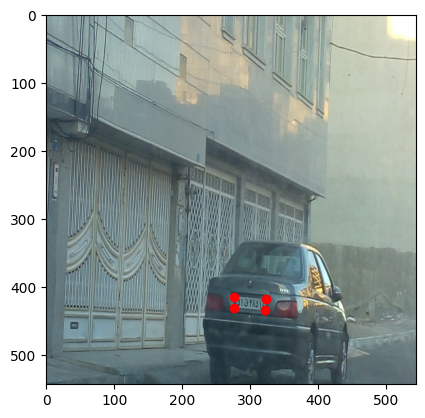

image    (544, 544, 3)


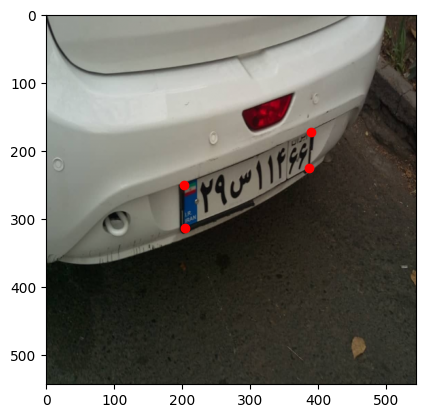

image    (544, 544, 3)


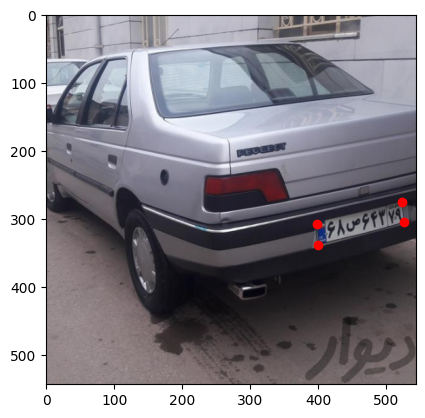

image    (544, 544, 3)


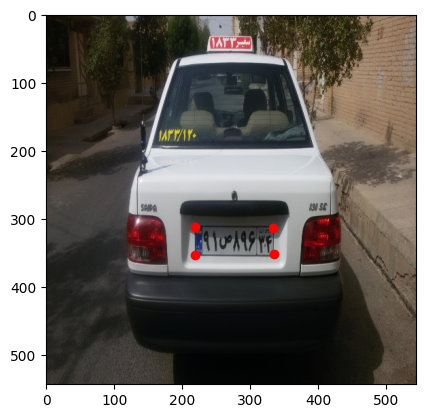

image    (544, 544, 3)


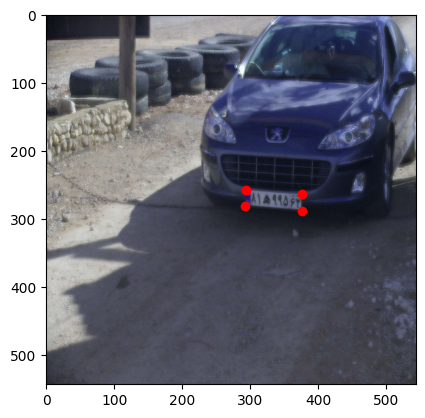

image    (544, 544, 3)


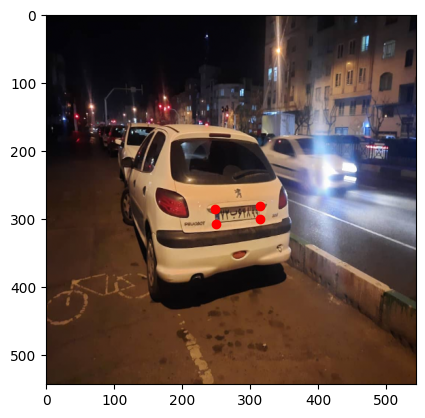

image    (544, 544, 3)


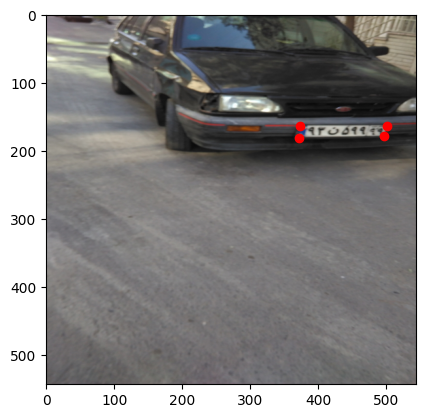

image    (544, 544, 3)


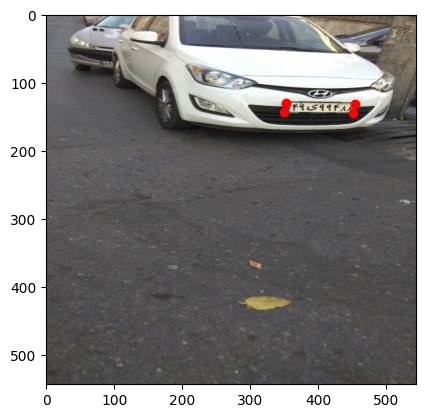

image    (544, 544, 3)


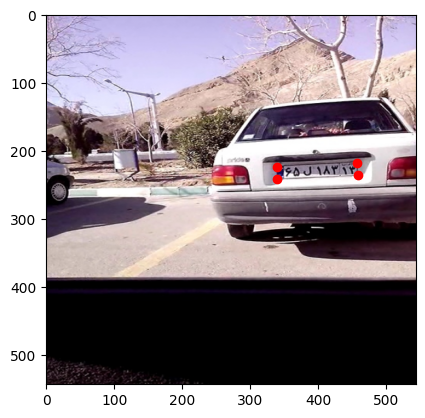

image    (544, 544, 3)


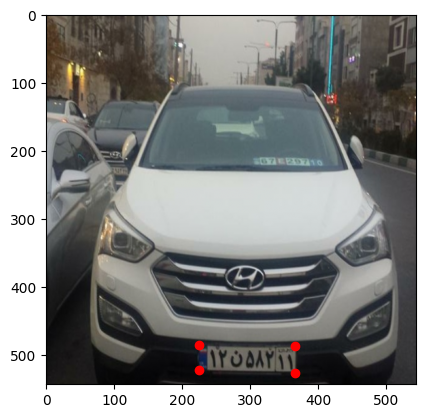

In [29]:
count = 0
for x,y in train_loader:
  image = x[0,:,:,:].numpy()
  label = y[0].numpy()
  print("image   ", image.shape)
  plt.imshow(image[:,:,::-1])
  xx = np.array(label)[[0,2,4,6]]
  yy = np.array(label)[[1,3,5,7]]
  plt.scatter([i*image.shape[1] for i in xx], [i*image.shape[0] for i in yy], color="red")
  plt.show()
  count +=1
  if count ==12:
    break


In [54]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.optimizers import Adam

model_plate =keras.models.Sequential([
    keras.layers.Conv2D(10, 4, activation="relu",padding="same"),
    # keras.layers.Dropout(0.1),
    keras.layers.MaxPooling2D(2),
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2D(40, 3, activation="relu", padding="same"),
    keras.layers.AveragePooling2D(2),
    # keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(8)
])

In [55]:
model_plate.compile(loss= "mse",
              optimizer="adam",
              metrics=["mean_absolute_error"])

In [56]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/training_1/.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model_plate.fit(train_loader,validation_data=val_loader, epochs=30,callbacks=[cp_callback])

In [57]:
model_plate.load_weights("/content/drive/MyDrive/Colab Notebooks/training_1/weights.h5")

In [16]:
from sklearn.metrics import mean_squared_error
### evaluate

def corners(image: np.ndarray, label, points) -> np.ndarray:
  plt.imshow(image[:,:,::-1])
  xx = np.array(label)[[0,2,4,6]]
  yy = np.array(label)[[1,3,5,7]]
  plt.scatter([i*image.shape[1] for i in xx], [i*image.shape[0] for i in yy], color="red")
  plt.show()
  mse = mean_squared_error(points, label)
  print(mse)
  return mse

In [ ]:
lm =[]
for img, lbl in val_loader:
  out = model_plate(img)
  for i in range(len(img)):
    image = img[i,:,:,:].numpy()
    label = out[i].numpy()
    points = lbl[i].numpy()
    lm.append(corners(image,label,points))
  break

lm = np.array(lm)

In [50]:
z_out, pts = rotation(im, ln)
plt.imshow(im)
plt.show()
plt.imshow(z_out[:,:,::-1])
plt.scatter([i*z_out.shape[1] for i in pts[:,0]], [i*z_out.shape[0] for i in pts[:,1]], color="red")
plt.show()

In [ ]:
z_out, pts = crop(im, ln)
plt.imshow(im)
plt.show()
plt.imshow(z_out)
plt.scatter([i*z_out.shape[1] for i in pts[:,0]], [i*z_out.shape[0] for i in pts[:,1]], color="red")
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!git clone https://github.com/kntu-utils/license-plate-generator.git

Cloning into 'license-plate-generator'...
remote: Enumerating objects: 721, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 721 (delta 6), reused 11 (delta 4), pack-reused 691
Receiving objects: 100% (721/721), 104.59 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Updating files: 100% (202/202), done.


In [ ]:
! pip install jsonnet-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jsonnet-binary: filename=jsonnet_binary-0.17.0-cp310-cp310-linux_x86_64.whl size=5628135 sha256=6a0b89f02bd69536639d6254de5fcab8fb12921330f3b5b55ba0b281a8866cfd
  Stored in directory: /root/.cache/pip/wheels/38/e3/a4/2e00888916cd70d1148611b3ea207de668e0af185f74fc68d1
Successfully built jsonnet-binary


In [ ]:
! pip install --upgrade -r "/content/drive/MyDrive/Colab Notebooks/license-plate-generator/requirements.txt"

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/license-plate-generator"

/content/drive/MyDrive/Colab Notebooks/license-plate-generator


In [ ]:
! python main.py --count 5000 --no-fill --no-transform


init components...
libpng warning: iCCP: known incorrect sRGB profile

loading backgrounds (pack 0)...
100% 1/1 [00:00<00:00, 34.76it/s]

generating 5000 images.
100% 5000/5000 [02:05<00:00, 39.79it/s]

generating xmls...
100% 5000/5000 [03:38<00:00, 22.86it/s]


In [11]:
import os
plates = os.listdir('/content/drive/MyDrive/Colab Notebooks/license-plate-generator/output/00/imgs')

In [12]:
chars = os.listdir('/content/drive/MyDrive/Colab Notebooks/license-plate-generator/output/00/anns/xmls')

In [40]:
def augment_2(image: np.ndarray,points: np.ndarray) -> tuple[np.ndarray,np.ndarray]:
    n = randint(0,100)
    # if random() < 0.1:
    if (n % 2) == 0:
        image = blurring(image)
    if (n % 3) == 0:
        image = contrast(image)
    # if (n % 5) == 0:
    #     image = crop(image)
    if (n % 7) == 0:
        image = shift(image, (random()/12,random()/12))
    if (n % 11) == 0:
        image = rotation(image)
    image = np.array(image)
    image = np.resize(image, (176,800, 3))
    return image , points

def blurring(image: np.ndarray):
    return cv2.blur(image, (10, 10))

def contrast(image: np.ndarray):
    return cv2.convertScaleAbs(image, alpha=0.9, beta=0)

def shift(img, shift):

    dy = int(shift[0] * img.shape[0])
    dx = int(shift[1] * img.shape[1])
    X = img
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return np.array(X)


def rotation(image):
  angle = np.random.randint(6)
  height, width = image.shape[:2]

  M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1.0)
  output = cv2.warpAffine(image, M, (width, height))

  return np.array(output)

def crop(img):

    h, w = img.shape[:2]


    X = img[(np.random.rand()*w/50): (w-(np.random.rand()*w/50)), (np.random.rand()*h/50) : (h-(np.random.rand()*h/50)),:]
    X = cv2.resize(X, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    return X

def resize(image: np.ndarray) -> tuple[np.ndarray]:
    img_shape = (176, 800,3)
    img = np.resize(image, img_shape)
    points = points
    return np.array(img)

In [41]:
# Optional
class PlateDataGenerator2(tf.keras.utils.Sequence):
    def __init__(self, data_frame, batch_size=32, img_shape=None):
        self.data_frame = data_frame
        self.train_len = len(data_frame)
        self.batch_size = batch_size
        self.img_shape = img_shape
        # self.path = train_dir
        self.path = '/content/drive/MyDrive/Colab Notebooks/license-plate-generator/output/00/'

    def __len__(self):
        shuffle(self.data_frame)
        return math.ceil(self.train_len/self.batch_size)

    def on_epoch_end(self):
        shuffle(self.data_frame)

    def __get_image(self, file_id):
        img = cv2.imread(self.path+"imgs/"+file_id)
        img = cv2.resize(img, self.img_shape)
        img = np.asarray(img)/255
        return np.array(img)

    def __get_label(self, label_id):
        label_id = label_id.replace('jpg','txt')
        label_name = self.path+"anns/xmls/"+label_id
        lb = []
        with open(label_name, "r") as f:
          for j in range(8):
            ln = f.readline()
            ln = ln.replace('\n','')
            ln = ln.split(' ')
            ln = [float(i) for i in ln]
            lb.append(ln)
        lb.sort(key=lambda x: x[1])
        output=[]
        for i in lb:
          output.append(i[0])
        output = np.array(output)
        return output

    def __getitem__(self, idx):
        batch_x = self.data_frame[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.data_frame[idx * self.batch_size:(idx + 1) * self.batch_size]
        x = [self.__get_image(file_id) for file_id in batch_x]
        y = [self.__get_label(label_id) for label_id in batch_y]
        for i in range(len(x)):
          new_x, new_y = augment_2(x[i], y[i])
          x.append(new_x)
          y.append(new_y)
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.uint8)
        return tf.convert_to_tensor(x), tf.one_hot(tf.convert_to_tensor(y), 42)

In [42]:
val_size = 0.2
shuffle(plates)
train_size = int(len(plates) * (1-val_size))
train_list = plates[:train_size]
val_list = plates[train_size:]

In [43]:
train_b = PlateDataGenerator2(train_list, img_shape=(800,176))
validation = PlateDataGenerator2(val_list, img_shape=(800,176))

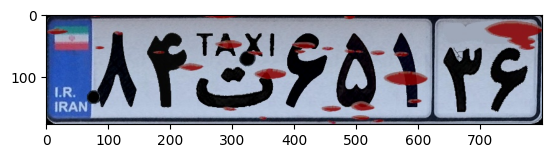

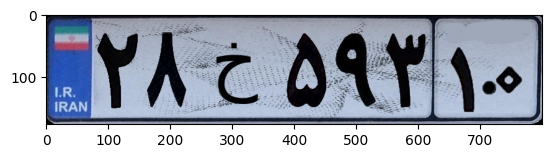

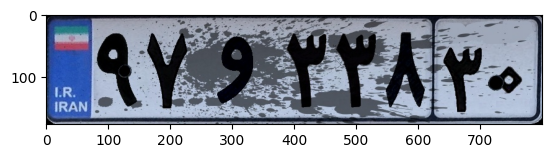

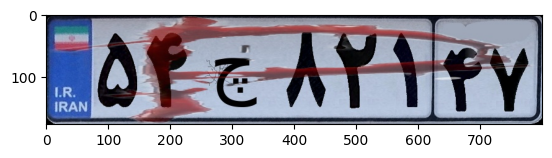

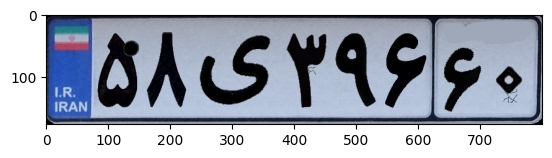

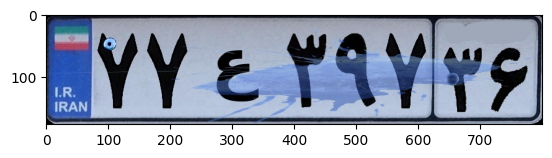

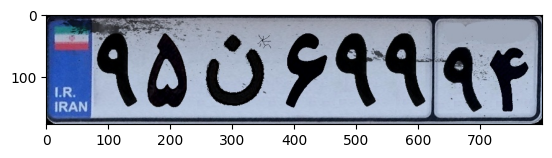

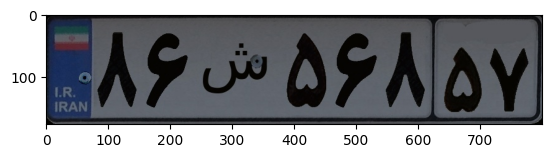

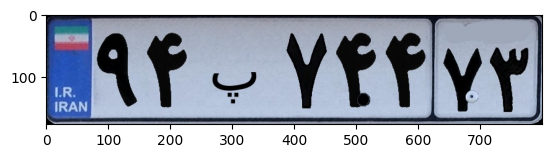

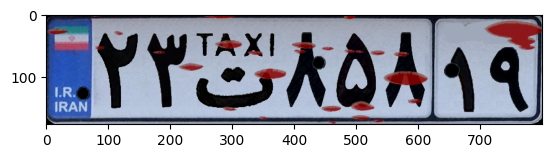

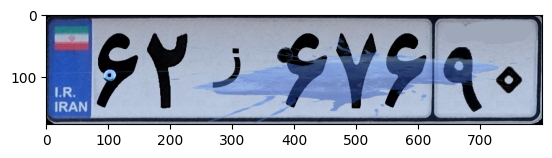

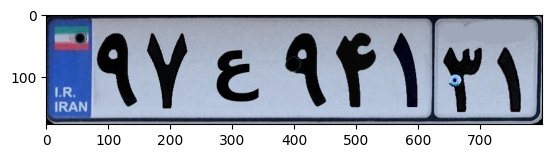

In [45]:
count = 0
for x,y in train_b:
  # print("x shape    ", x.shape)
  # print("y shape    ", y.shape)
  image = x[0,:,:,:].numpy()
  label = y[0].numpy()
  # print("image   ", image.shape)
  # print(label)
  plt.imshow(image[:,:,::-1])
  plt.show()
  count +=1
  if count ==12:
    break

In [81]:
class PlateNet(tf.keras.Model):
  def __init__(self):
    super(PlateNet, self).__init__()
    self.conv_lay1 = tf.keras.layers.Conv2D(64, strides=(2, 2), kernel_size=(3, 3), activation='relu')
    self.act_lay1 = tf.keras.layers.Activation('relu')
    self.batchnorm_lay1 = tf.keras.layers.BatchNormalization(axis=3)

    self.pooling = tf.keras.layers.MaxPooling2D(2)


    OUTPUT_CLASSES = 42

    self.flat_lay = tf.keras.layers.Flatten()
    self.dense_0 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_1 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_2 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_3 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_4 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_5 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_6 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    self.dense_7 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    # self.dense_8 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
    # self.dense_9 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')

  def call(self, x_input):
    x = self.conv_lay1(x_input)
    x = self.act_lay1(x)
    x = self.batchnorm_lay1(x)
    x = self.pooling(x)
    split_x = tf.split(x, num_or_size_splits=8, axis=-1)
    outs = []
    for i in range(len(split_x)):
      df = getattr(self, "dense_"+str(i))
      flat_x = self.flat_lay(split_x[i])
      out_x = df(flat_x)
      outs.append(out_x)
    outs = tf.stack((outs), axis=1)
    return outs


In [82]:
model = PlateNet()
model.compile(loss= "mse",
    optimizer="adam",
    metrics=["mean_absolute_error"])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/training_2/.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_b,validation_data=validation, epochs=30,callbacks=[cp_callback])

In [83]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/training_2/weights.h5")

In [ ]:
keras.models.load_model(checkpoint_filepath)

In [49]:
dict = { 0:'', 1:'0' , 2:'1' ,3:'2', 4:'3', 5:'4', 6:'5', 7:'6', 8:'7', 9:'8', 10:'9', 11:'A', 12:'B', 13:'P', 14:'T', 15:'S', 16:'J', 17:'CH', 18:'HE', 19:'KH', 20:'D', 21:'Z', 22:'R',
        23:'ZE', 24:'ZH', 25:'SIN', 26:'SHIN', 27:'SAD', 28:'ZAD', 29:'TA', 30:'ZA', 31:'AIN', 32:'GHAIN', 33:'F', 34:'Q', 35:'K', 36:'G', 37:'L', 38:'M', 39:'N', 40:'V', 41:'H', 42:'Y', 43:'IRAN', 44:'Plate'}

In [47]:
def trans_to_char(list):
  str =""
  for i in list:
    str = str + dict[int(i)]
  return str

In [ ]:
from sklearn.metrics import mean_squared_error
acc = []
for img,chars in validation:
  out = model(img)
  for i in range(len(img)):
    image = img[i,:,:,:].numpy()
    plate = chars[i].numpy()
    pred = out[i].numpy()
    plt.imshow(image[:,:,::-1])
    plt.show()
    ch = tf.argmax(pred, axis=-1)
    print(ch)
    print(trans_to_char(np.array(ch)))
    acc.append(mean_squared_error(plate,pred))
  break

In [51]:
acc = np.array(acc)
print(np.mean(acc))

0.023266664


In [63]:
def single_plate(image):
  # image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/four-corners/images/1.jpg")
  image = cv2.resize(image,(544,544))
  image = np.asarray(image)/255
  img = np.array(image).astype(np.float32)
  img = np.expand_dims(img, axis=0)
  img = tf.convert_to_tensor(img)
  # print("sh 4    ", image.shape)
  # label = "/content/drive/MyDrive/Colab Notebooks/four-corners/labels/1.txt"
  # with open(label, "r") as f:
  #   ln = f.readline()
  # ln = ln.replace('\n','')
  # ln = ln.split(' ')
  # ln = ln[1:]
  # ln = [float(i) for i in ln]
  # label = ln.copy()
  out = model_plate(img)
  m = 800
  n = 176
  output_size = (m,n)
  out = np.array(out)
  out = out[0]
  points = np.array([(out[0],out[1]),(out[2],out[3]),(out[4],out[5]),(out[6],out[7])]).astype(np.float32)
  points2 = np.array([(0, 0), (m, 0), (m, n), (0, n)]).astype(np.float32)
  H = cv2.getPerspectiveTransform(points, points2)
  J = cv2.warpPerspective(image, H, output_size)
  plt.imshow(J[:,:,::-1])
  plt.show()
  J = np.asarray(J)/255
  J = np.array(J).astype(np.float32)
  J = np.expand_dims(J, axis=0)
  J = tf.convert_to_tensor(J)
  plate_chars = model(J)
  ch = tf.argmax(plate_chars, axis=-1)
  ch = np.array(ch)[0]
  # print(ch)
  # print(np.array(ch))
  ch = trans_to_char(np.array(ch))
  # print("PLATE: ",ch)
  return ch

In [ ]:
inp = cv2.imread("/content/drive/MyDrive/Colab Notebooks/four-corners/images/12.jpg")
print(single_plate(inp))

In [68]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [75]:
from ultralytics import YOLO

model_yolo = YOLO("yolov8n.pt")

results = model_yolo(["/content/drive/MyDrive/Colab Notebooks/multiple-cars/day_08626.jpg"])

# Export the model to ONNX format
success = model_yolo.export(format="onnx")


0: 480x640 2 persons, 4 cars, 174.7ms
Speed: 3.1ms preprocess, 174.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 1.0s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (2.7s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


In [76]:
for result in results:
    result.show()

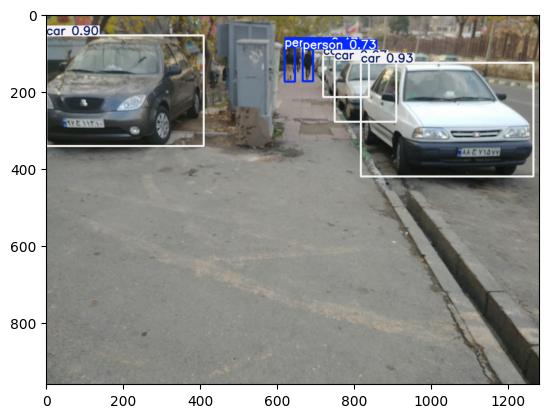

In [77]:
from PIL import Image
import matplotlib.pyplot as plt
im_array = results[0].plot()
im = Image.fromarray(im_array[..., ::-1])
plt.imshow(im)
plt.show()

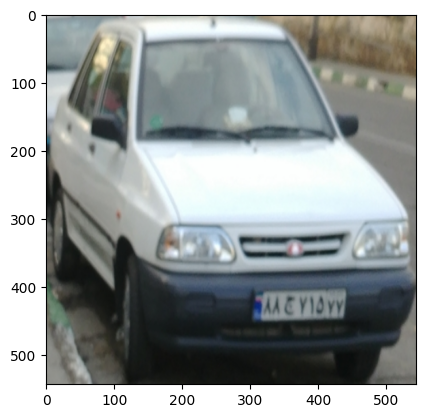

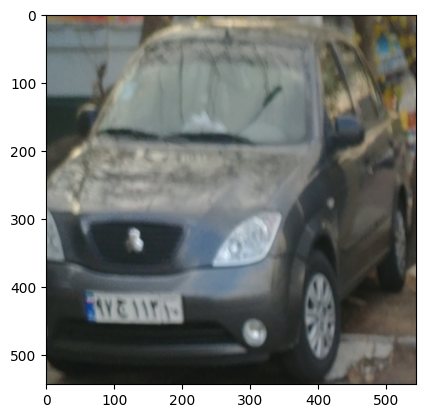

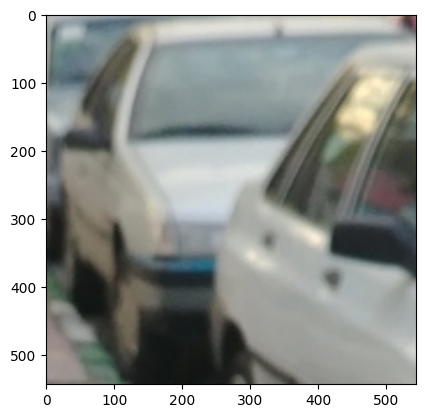

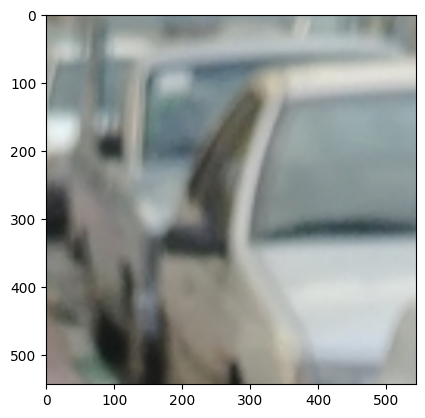

In [78]:
import numpy as np
import cv2
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/multiple-cars/day_08626.jpg")
multiple_images = []
for i in range(len(results[0].boxes.cls)):
  if results[0].boxes.cls[i] == 2:
    box = np.array(results[0].boxes.xywh[i])
    x = box[0]
    y = box[1]
    w = box[2]/2
    h = box[3]/2
    J = np.copy(image[int(y-h):int(y+h), int(x-w):int(x+w)])
    J = cv2.resize(J, (544, 544))
    J = J[:,:,::-1]
    multiple_images.append(J)
    plt.imshow(J)
    plt.show()

In [ ]:
for i in multiple_images:
  image = np.asarray(i)/255
  img = np.array(image).astype(np.float32)
  img = np.expand_dims(img, axis=0)
  img = tf.convert_to_tensor(img)
  out = model_plate(img)
  m = 800
  n = 176
  output_size = (m,n)
  out = np.array(out)
  out = out[0]
  points = np.array([(out[0],out[1]),(out[2],out[3]),(out[4],out[5]),(out[6],out[7])]).astype(np.float32)
  points2 = np.array([(0, 0), (m, 0), (m, n), (0, n)]).astype(np.float32)
  H = cv2.getPerspectiveTransform(points, points2)
  J = cv2.warpPerspective(image, H, output_size)
  plt.imshow(J[:,:,::-1])
  plt.show()
  J = np.asarray(J)/255
  J = np.array(J).astype(np.float32)
  J = np.expand_dims(J, axis=0)
  J = tf.convert_to_tensor(J)
  plate_chars = model(J)
  ch = tf.argmax(plate_chars, axis=-1)
  ch = np.array(ch)[0]
  ch = trans_to_char(np.array(ch))
  print("PLATE: ",ch)
